In [2]:
#TO-DO LIST: finish velocity distribution code, finish equivalent width code, finish find_point error code,
#add for loop, finish silicon ratio code, make polyfit error code, build new t_max dictionary, 
#make intrinsic color vs. Si_ratio graph, make all figures for poster

#improvements: better way to determina maxima for silicon ratio and equivalent width

#of immediate urgency: finish up silicon ratio, eq width, t_0 parse 

In [3]:
%matplotlib inline 
import math
import matplotlib.pyplot as plt
import numpy as np 
import glob as glob
import random
from statistics import mode
from numpy import trapz
from astropy.time import Time
from bs4 import BeautifulSoup
import urllib
import urllib.request
import urllib.response
from astroquery.ned import Ned
c = 299792 #speed of light in km/s

In [4]:
def gsmooth(x_array, y_array, var_y, vexp = .001, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [5]:
def autosmooth(x_array, y_array, var_y):
    new_y_init = gsmooth(x_array, y_array, var_y, .001)
    SNR = np.mean(new_y_init / flux_error)
    
    if SNR < 5:
        vexp_auto = .0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .002
    elif 20 <= SNR < 40:
        vexp_auto = .0015
    elif 40 <= SNR < 60:
        vexp_auto = .001
    elif 60 <= SNR < 100:
        vexp_auto = .00075
    else:
        vexp_auto = .0005
    
    new_y = gsmooth(x_array, y_array, var_y, vexp_auto)
    return new_y

In [6]:
def get_SN_name(file):
    SN_name = file.split('-')[0]
    return SN_name

In [7]:
#still needs to be fine-tuned for odd cases (lack of sigfigs)
def find_z(SN_name):
    if SN_name == "sn2007if":
        z = 0.0742
    elif SN_name == "sn2007kf":
        z = 0.0460
    elif SN_name == "sn2007kg":
        z = .0070
    elif SN_name == "sn2007kh":
        z = 0.0500
    elif SN_name == "sn2008cf":
        z = 0.0460
    elif SN_name == "sn2008hm":
        z = 0.0197
    elif SN_name == "sn2009lf":
        z = 0.0450
    elif SN_name == "snf20080522000":
        z = 0.0472
    elif SN_name == "snf20080522011":
        z = 0.0397
    elif SN_name == "PTF10bjs":
        z = 0.0300
    
    else:
        query_url = 'https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=sn2007fs&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES'
        sn_url = query_url.replace("sn2007fs", SN_name)
        response = urllib.request.urlopen(sn_url)
        ned_html = response.read()
        soup = BeautifulSoup(ned_html, 'html.parser')
        ned_text = soup.get_text().split('\n')
        for i in range(len(ned_text)):
            if 'CROSS-IDENTIFICATIONS' in ned_text[i]:
                break
        cross_id_text = ned_text[i:i+5]
        for line in cross_id_text:
            if ':' in line:
                cut1 = line.split('SN')
                for el in cut1:
                    if ':' in el:
                        galaxy = el.split(':')[0].strip()
                        data = Ned.get_table(galaxy, table = 'redshifts')
                        tablelength = len(data)
                        z = data[0][4]
    return z

In [8]:
def build_peak_dict(files):
    peak_mjd_dict = {}
    for file in files:
        with open(file) as f:
            lines = f.readlines()

            #peak_mjd_dict = {}
            for line in lines:
                l = line.split()
                if len(l) == 38 and l[0] == 'SN:':
                    peak_mjd_dict[l[1].lower()] = float(l[18])
    
    return peak_mjd_dict

files = glob.glob("FITOPT000*")
peak_mjd_dict = build_peak_dict(files)
print(peak_mjd_dict)


#check which I have both sets of data for
#file_list = glob.glob("*.flm")
#names_list = []
#for a in file_list:
    #names_list.append(get_SN_name(a))

#for SN in SN_list:
    #if SN[2:] in peak_mjd_dict:
        #if SN in names_list:
            #print (SN)
        

{'2006ct': 53884.684, '2006ou': 54085.297, '2007a': 54113.398, '2007aj': 54160.574, '2007bj': 54199.105, '2007cb': 54214.777, '2007cc': 54216.301, '2007cf': 54226.098, '2007cn': 54256.191, '2007cs': 54275.738, '2007ev': 54280.113, '2007fb': 54288.07, '2007fs': 54293.891, '2007hg': 54346.621, '2007hu': 54352.93, '2007ir': 54353.961, '2007is': 54366.703, '2007jg': 54366.082, '2007kd': 54369.867, '2007kh': 54365.879, '2007kk': 54383.77, '2007nq': 54398.25, '2007ob': 54402.379, '2007rx': 54439.914, '2007ss': 54453.695, '2007su': 54460.504, '2007sw': 54468.496, '2007ux': 54465.812, '2008c': 54467.301, '2008y': 54503.711, '2008z': 54515.574, '2008ac': 54503.695, '2008ad': 54494.801, '2008ae': 54511.992, '2008ai': 54508.711, '2008ar': 54534.727, '2008at': 54526.602, '2008bi': 54548.594, '2008bw': 54565.422, '2008by': 54575.039, '2008bz': 54577.863, '2008cf': 54595.078, '2008dr': 54662.984, '2008ds': 54652.633, '2008dt': 54647.973, '2008fr': 54732.578, '2008gb': 54747.047, '2008gl': 54768.484,

In [9]:
class supernova:
    def __init__(self, name, z):
        self.name = name
        self.spectra = []
        self.z = z

In [10]:
SN_list = []
file = glob.glob("CfA4_info.txt")[0]
sn_datatext = open(file, "r")
sn_datainfo = sn_datatext.readlines()
start_line = 60
for line in sn_datainfo[start_line:]:
    line_elems = line.split()
    temp = line_elems[0]
    if temp[0] == "2":
        name = "sn" + temp
    else:
        name = temp
    SN_list.append(name)
    
#create array of all objects with fields of supernova class populated
spectra_list = []
z_list = []

print ("Getting redshifts from NED and making supernova objects...")
for SN in SN_list:
    associated_z = find_z(SN)
    z_list.append(associated_z)
    
SN_object_list = []
for a in range(0, len(SN_list)):    
    SN_object = supernova(SN_list[a], z_list[a])
    SN_object_list.append(SN_object)
    print (SN_object.name)

Getting redshifts from NED and making supernova objects...
sn2006ct
sn2006ou
sn2007A
sn2007aj
sn2007bj
sn2007cb
sn2007cc
sn2007cf
sn2007cn
sn2007cs
sn2007ev
sn2007fb
sn2007fq
sn2007fs
sn2007hg
sn2007hj
sn2007hu
sn2007if
sn2007ir
sn2007is
sn2007jg
sn2007kd
sn2007kf
sn2007kg
sn2007kh
sn2007kk
sn2007le
sn2007nq
sn2007ob
sn2007rx
sn2007ss
sn2007su
sn2007sw
sn2007ux
sn2008A
sn2008C
sn2008Q
sn2008Y
sn2008Z
sn2008ac
sn2008ad
sn2008ae
sn2008ai
sn2008ar
sn2008at
sn2008bi
sn2008bw
sn2008by
sn2008bz
sn2008cd
sn2008cf
sn2008cm
sn2008dr
sn2008ds
sn2008dt
sn2008fr
sn2008gb
sn2008gl
sn2008hj
sn2008hm
sn2008hs
sn2008hv
sn2009D
sn2009Y
sn2009ad
sn2009al
sn2009an
sn2009bv
sn2009dc
sn2009do
sn2009ds
sn2009fv
sn2009gf
sn2009hp
sn2009ig
sn2009jr
sn2009kk
sn2009kq
sn2009le
sn2009lf
sn2009li
sn2009na
sn2009nq
sn2010A
sn2010H
sn2010Y
sn2010ag
sn2010ai
sn2010cr
sn2010dt
sn2010dw
snf20080522000
snf20080522011
PTF10bjs


In [11]:
class spectrum:
    def __init__(self, filename, events):
        self.filename = filename
        print ("Creating: ", self.filename)
        self.wavelength, self.flux, self.flux_error = np.loadtxt(self.filename, unpack = True)
        #self.wavelength= np.loadtxt(self.filename, unpack = True)
        self.z = find_z(get_SN_name(self.filename))
        self.event = self.find_match(events)
        self.update_event_spectra_list()
        self.deredwavelength = self.cderedshift()
    
    
    def __eq__(self, other):
        return self.filename == other.filename
    
    def find_match(self, events):   #how to initialize this as self.event? 
        match_list = []
        for a in events:
            if a.name in self.filename:
                ev = a
                print (ev.name)
                return ev
        
    def update_event_spectra_list(self):
        if self not in self.event.spectra:
            self.event.spectra.append(self)
        else:
            i = self.event.spectra.index(self)
            self.event.spectra[i] = self
    
    def plot_spectrum(self):
        plt.figure(figsize=(20, 10))
        plt.axvline(x=6355, linewidth=.5)
        #resting wavelength of Si II
        plt.plot(self.deredwavelength, self.flux, linewidth=1, color='grey')
        plt.plot(self.deredwavelength, self.csm_flux(), linewidth=1, color='blue')
        plt.xlabel('Wavelength (Angstroms)')
        plt.ylabel('Relative Flux')
    
    def snr(self):
        temp_flux = gsmooth(self.wavelength, self.flux, self.flux_error, .001)
        snr = np.mean(temp_flux / self.flux_error)
        return snr
    
    def csm_flux(self):
        if self.snr() < 5:
            vexp_auto = .0025
        elif 5 <= self.snr() < 20:
            vexp_auto = .002
        elif 20 <= self.snr() < 40:
            vexp_auto = .0015
        elif 40 <= self.snr() < 60:
            vexp_auto = .001
        elif 60 <= self.snr() < 100:
            vexp_auto = .00075
        else:
            vexp_auto = .0005
        
        sm_flux = gsmooth(self.wavelength, self.flux, self.flux_error, vexp_auto)
        return sm_flux
    
    def cderedshift(self):
        cderedwavelength = self.wavelength / (1 + self.z)
        return cderedwavelength
    
    def min_wave(self, error = False, w1 = 5900, w2 = 6500, n = 1000):
        wave_domain = np.where((self.deredwavelength > w1) & (self.deredwavelength < w2)) #set domain as within minwave and maxwave
        list(wave_domain)
        flux_range = self.csm_flux()[wave_domain] #find corresponding flux vales for wavelengths within domain
        elem_flux = min(flux_range) #find minimum value within these flux vales to locate "dip"
        min_wave = self.deredwavelength[np.where(self.csm_flux() == elem_flux)][0] #find the corresponding wavelength
        
        local_flux_error = self.flux_error[wave_domain]
        local_median_error = np.median(local_flux_error)
        
        if error == True:
            flux_dist = []
            for i in range(n):
                point_sample = np.random.normal(elem_flux, local_median_error)
                flux_dist.append(point_sample)
        
            lower68bound = sorted(flux_dist)[int(round(n * .16)) - 1]
            upper68bound = sorted(flux_dist)[int(round(n * .84)) - 1]
            sigma = local_median_error
            return min_wave, sigma, lower68bound, upper68bound
        
        else:
            return min_wave
    
    def max_wave(self, error = False, w1 = 5900, w2 = 6500, n = 1000):
        wave_domain = np.where((self.deredwavelength > w1) & (self.deredwavelength < w2)) #set domain as within minwave and maxwave
        list(wave_domain)
        flux_range = self.csm_flux()[wave_domain] #find corresponding flux vales for wavelengths within domain
        elem_flux = max(flux_range) #find minimum value within these flux vales to locate "dip"
        max_wave = self.deredwavelength[np.where(self.csm_flux() == elem_flux)][0] #find the corresponding wavelength
        
        local_flux_error = self.flux_error[wave_domain]
        local_median_error = np.median(local_flux_error)
        
        if error == True:
            flux_dist = []
            for i in range(n):
                point_sample = np.random.normal(elem_flux, local_median_error)
                flux_dist.append(point_sample)
        
            lower68bound = sorted(flux_dist)[int(round(n * .16)) - 1]
            upper68bound = sorted(flux_dist)[int(round(n * .84)) - 1]
            sigma = local_median_error
            return max_wave, sigma, lower68bound, upper68bound
        
        else:
            return max_wave
    
    def eq_width(self):
        max_1 = self.max_wave(False, 5800, 6100)
        max_2 = self.max_wave(False, 6250, 6450)
        
        domain = np.where((self.deredwavelength >= max_1) & (self.deredwavelength <= max_2))
        list(domain)
        wave_range = self.deredwavelength[domain]
        flux_range = self.flux[domain]
        
        line_elem = np.polyfit([max_1, max_2], [self.csm_flux()[np.where(self.deredwavelength == max_1)],
                                                self.csm_flux()[np.where(self.deredwavelength == max_2)]], 1)
        #print(line_elem)
        line = line_elem[0] * wave_range + line_elem[1]
        #ask about this
        
        norm = flux_range / line
        #new_norm = norm * 0 + 0.3
        #print (new_norm)
        

        a_curve = trapz((norm), x = wave_range)
        a_line = max(wave_range) - min(wave_range)
        
        eq_width = a_line - a_curve
        
        #plt.plot(norm, color = 'black')
        #plt.plot(wave_range, norm, color = "orange")
        #plt.plot(wave_range , 1, color = "yellow")
        #plt.axvline (x=max_1, color = 'red')
        #plt.axvline (x=max_2, color = 'blue')
    
        return eq_width
     
    def si_ratio(self):
        #max_1_wave = find_max_wave(dered_wave,sm_flux, 5800, 6100)
        #max_2_wave = find_max_wave(dered_wave,sm_flux, 6250, 6450)
        #max_3_wave = find_max_wave(dered_wave, sm_flux, 5600, 5700)
        
        #min_2_wave = find_min_wave(dered_wave, sm_flux, 5900, 6400)
        #min_1_wave = find_min_wave(dered_wave, sm_flux, 5600, 5900)
        
        max_1 = self.max_wave(False, 5600, 5700)
        max_2 = self.max_wave(False, 5800, 6100)
        max_3 = self.max_wave(False, 6250, 6450)
        
        min_1 = self.min_wave(False, 5600, 5900)
        min_2 = self.min_wave(False, 5900, 6400)
        
        eqw_domain_2 = np.where((self.deredwavelength >= max_2) & (self.deredwavelength <= max_3))
        list(eqw_domain_2)
        line_elem = np.polyfit([max_2, max_3], [self.csm_flux()[np.where(self.deredwavelength == max_2)], 
        self.csm_flux()[np.where(self.deredwavelength == max_3)]],1)
        big_silc_line_flux = line_elem[0]*min_2 + line_elem[1]
        big_silc_dip_flux = self.csm_flux()[np.where(self.deredwavelength == min_2)]
        big_silc = big_silc_line_flux - big_silc_dip_flux
    
        eqw_domain_1 = np.where((self.deredwavelength >= max_1) & (self.deredwavelength <= max_2))
        list(eqw_domain_1)
        line_elem = np.polyfit([max_1, max_2], [self.csm_flux()[np.where(self.deredwavelength == max_1)], 
        self.csm_flux()[np.where(self.deredwavelength == max_2)]],1)
        small_silc_line_flux = line_elem[0]*min_1 + line_elem[1]
        small_silc_dip_flux = self.csm_flux()[np.where(self.deredwavelength == min_1)]
        small_silc = small_silc_line_flux - small_silc_dip_flux
    
        #print (big_silc_dip_flux)
        #print (small_silc_dip_flux)
        #print (big_silc_line_flux)
        #print (small_silc_line_flux)
    
        si_ratio = small_silc/big_silc
        return si_ratio[0]
        
    def velocity(self, rest_wave = 6355):
        wave_prop = self.min_wave() / rest_wave
        ejecta_velocity = ejecta_velocity = c * (wave_prop ** 2 - 1) / (wave_prop ** 2 + 1)
        return ejecta_velocity
  
    def sigma_v(self, n = 1000, w1 = 5900, w2 = 6500, rest_wave = 6355):
        vel_dist = []
        if self.snr() < 5:
            vexp_auto = .0025
        elif 5 <= self.snr() < 20:
            vexp_auto = .002
        elif 20 <= self.snr() < 40:
            vexp_auto = .0015
        elif 40 <= self.snr() < 60:
            vexp_auto = .001
        elif 60 <= self.snr() < 100:
            vexp_auto = .00075
        else:
            vexp_auto = .0005
            
        for i in range(n):
            vexp_sample = np.random.normal(vexp_auto, vexp_auto / 4)
            flux_sample = gsmooth(self.deredwavelength, self.flux, self.flux_error, vexp_sample)
            
            wave_domain = np.where((self.deredwavelength > w1) & (self.deredwavelength < w2)) #set domain as within minwave and maxwave
            list(wave_domain)
            flux_range = flux_sample[wave_domain] #find corresponding flux vales for wavelengths within domain
            elem_flux = min(flux_range) #find minimum value within these flux vales to locate "dip"
            min_wave = self.deredwavelength[np.where(flux_sample == elem_flux)][0] #find the corresponding wavelength
        
            wavelength_prop = min_wave / rest_wave
            ejecta_velocity = c * (wavelength_prop ** 2 - 1) / (wavelength_prop ** 2 + 1)
            vel_dist.append(ejecta_velocity)
            
        lower68bound = sorted(vel_dist)[int(round(n * .16)) - 1]
        upper68bound = sorted(vel_dist)[int(round(n * .84)) - 1]
    
        return lower68bound, upper68bound, vel_dist
    
    def t_obs(self):
        file = self.filename
        date = file.split('-')[1]
        datetime = date[0:4] + "-" + date[4:6] + "-" + date[6:]
        t = Time(datetime)
        t.format = 'mjd'    
        t_obs = t.value
        return t_obs
    
    def t_max(self):
        t_max = peak_mjd_dict.get(self.event.name[2:], "None")
        return t_max
    
    def phase(self):
        phase = (self.t_obs() - self.t_max()) / (1 + self.z)
        return phase
    
    def v_0(self):
        v = self.velocity()
        t = self.phase()
        
        v_0 = (v + (0.285 * t)) / (1 - (0.0322 * t))
        #sigma_v_0 = ((self.sigma_v() / (1 - 0.0322 * t)) ** 2 + 0.22 ** 2) ** (1/2)
        return v_0#, sigma_v_0
    
    def v_0_best(self):
        data = glob.glob(self.event.name + '*')
        phase_list= []
        
        for a in data:
            temp_object = spectrum(a, SN_object_list)
            phase = temp_object.phase()
            phase_list.append(abs(phase))
        
        print(data)
        print(phase_list)
        
        index = np.argmin(phase_list)
        best_object = spectrum(data[index], SN_object_list)
        
        v_0_best = best_object.v_0()
        return v_0_best
    
    
    def tot_ke(self):
        m = 2.86 #1.4 solar masses in 10 ** 33 g)
        v = self.v_0() * 100000 #velocity in cm/s
        ke = 0.5 * m * (v ** 2)
        return ke, "* 10^33 ergs"
    
    
    def intrinsic_color(self):
        B_maxMinusV_max_0 = -0.39 - (0.033 * self.v_0() / 1000)
        return B_maxMinusV_max_0

In [48]:
spectra = glob.glob("*.flm")
spectrum_object_list = []

for a in range(0, len(spectra)):    
    
    if get_SN_name(spectra[a]) not in SN_list:
        pass #associated supernova is not of CfA4
   
    elif len(np.loadtxt(spectra[a], unpack = True)) < 3:
        pass #spectrum is missing flux error
    
    else:
        spectrum_object = spectrum(spectra[a], SN_object_list)
        spectrum_object_list.append(spectrum_object)
        print(spectrum_object)

Creating:  sn2007A-20070110.14-fast.flm
sn2007A
Creating:  sn2007hu-20070911.14-fast.flm
sn2007hu
Creating:  sn2007is-20070919.14-fast.flm
sn2007is
Creating:  sn2007jg-20070920.46-fast.flm
sn2007jg
Creating:  sn2007nq-20071031.24-fast.flm
sn2007nq
Creating:  sn2007ob-20071107.14-fast.flm
sn2007ob
Creating:  sn2007su-20071229.08-fast.flm
sn2007su
Creating:  sn2007sw-20080103.52-fast.flm
sn2007sw
Creating:  sn2008at-20080305.30-fast.flm
sn2008at
Creating:  sn2008fr-20080930.422-ui.flm
sn2008fr
Creating:  sn2008fr-20081007.368-ui.flm
sn2008fr
Creating:  sn2008hj-20081205.296-ui.flm
sn2008hj
Creating:  sn2008Y-20080209.41-fast.flm
sn2008Y


In [49]:
best_spectrum_object_list = []
dupe_check = []

for a in spectrum_object_list:    
    if a.t_max() != "None":
        data = glob.glob(a.event.name + '*')
        for b in data:
            phase_list= []
            temp_object = spectrum(b, SN_object_list)
            phase = temp_object.phase()
            phase_list.append(abs(phase))
        
            #print(data)
            #print(phase_list)
        
            index = np.argmin(phase_list)
            best_object = spectrum(data[index], SN_object_list)
            
            if best_object.event.name not in dupe_check:
                dupe_check.append(best_object.event.name)
                best_spectrum_object_list.append(best_object)
            
            elif best_object.event.name in dupe_check:
                pass
                
#for b in best_spectrum_object_list:
    #print (b.event.name)

Creating:  sn2007hu-20070911.14-fast.flm
sn2007hu
Creating:  sn2007hu-20070911.14-fast.flm
sn2007hu
Creating:  sn2007is-20070919.14-fast.flm
sn2007is
Creating:  sn2007is-20070919.14-fast.flm
sn2007is
Creating:  sn2007jg-20070920.46-fast.flm
sn2007jg
Creating:  sn2007jg-20070920.46-fast.flm
sn2007jg
Creating:  sn2007nq-20071031.24-fast.flm
sn2007nq
Creating:  sn2007nq-20071031.24-fast.flm
sn2007nq
Creating:  sn2007ob-20071107.14-fast.flm
sn2007ob
Creating:  sn2007ob-20071107.14-fast.flm
sn2007ob
Creating:  sn2007su-20071229.08-fast.flm
sn2007su
Creating:  sn2007su-20071229.08-fast.flm
sn2007su
Creating:  sn2007sw-20080103.52-fast.flm
sn2007sw
Creating:  sn2007sw-20080103.52-fast.flm
sn2007sw
Creating:  sn2008at-20080305.30-fast.flm
sn2008at
Creating:  sn2008at-20080305.30-fast.flm
sn2008at
Creating:  sn2008fr-20080930.422-ui.flm
sn2008fr
Creating:  sn2008fr-20080930.422-ui.flm
sn2008fr
Creating:  sn2008fr-20081007.368-ui.flm
sn2008fr
Creating:  sn2008fr-20080930.422-ui.flm
sn2008fr
Crea

107.44604427501291 113.46131845794073 23.047445852299727


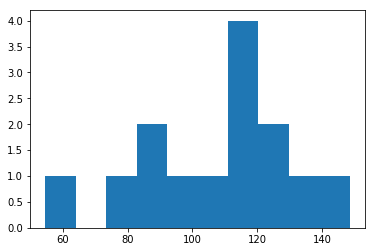

In [14]:
eq_width_list = []
for a in spectrum_object_list:
    eq_width_list.append(a.eq_width())

plt.hist(eq_width_list)
print(np.mean(eq_width_list), np.median(eq_width_list), np.std(eq_width_list))

Text(0,0.5,'(Bmax-Vmax)_0')

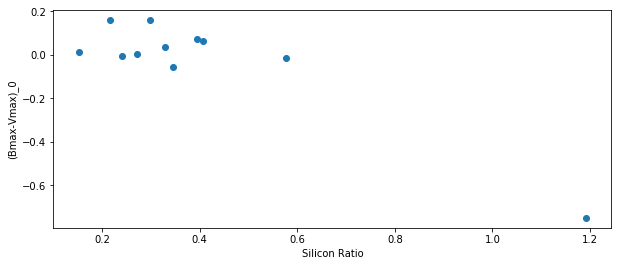

In [15]:
color_list = []
si_ratio_list = []

for object in best_spectrum_object_list:
    if object.t_max() != "None":
        color_list.append(object.intrinsic_color())
        si_ratio_list.append(object.si_ratio())

plt.figure(figsize=(10, 4))
plt.plot( si_ratio_list, color_list, linestyle = "", marker = "o")#, linewidth=1, color='blue')
plt.xlabel('Silicon Ratio')
plt.ylabel("(Bmax-Vmax)_0")


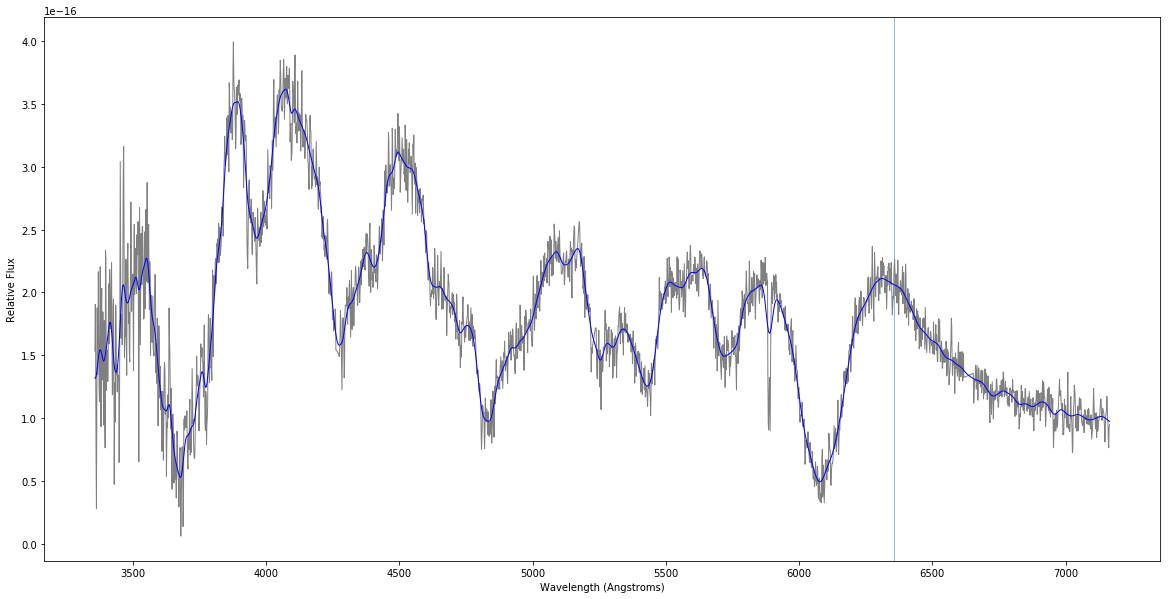

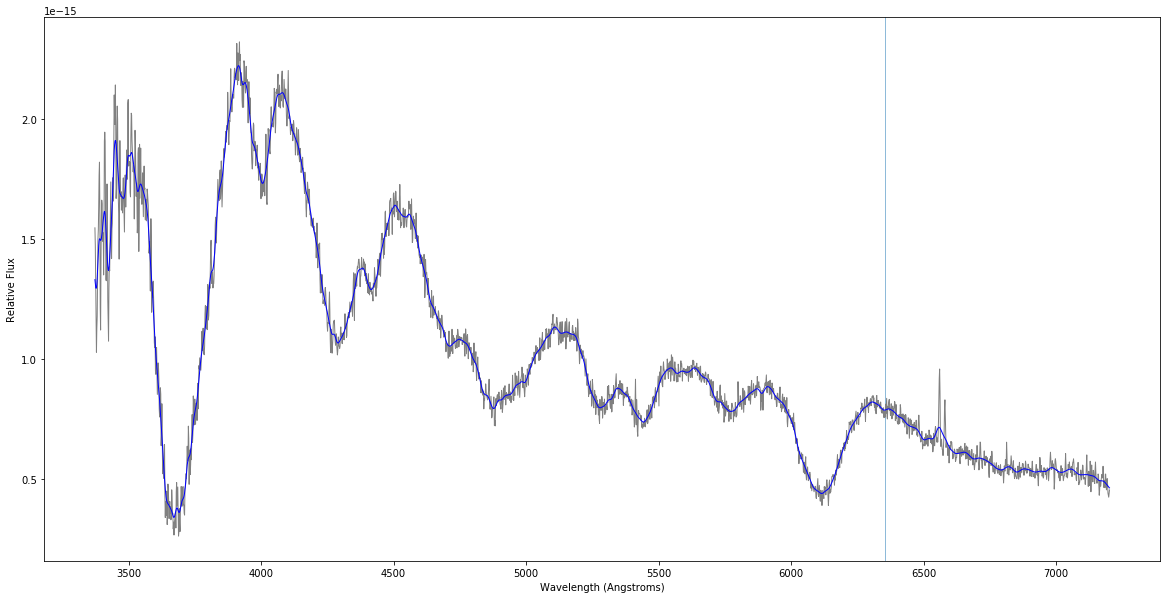

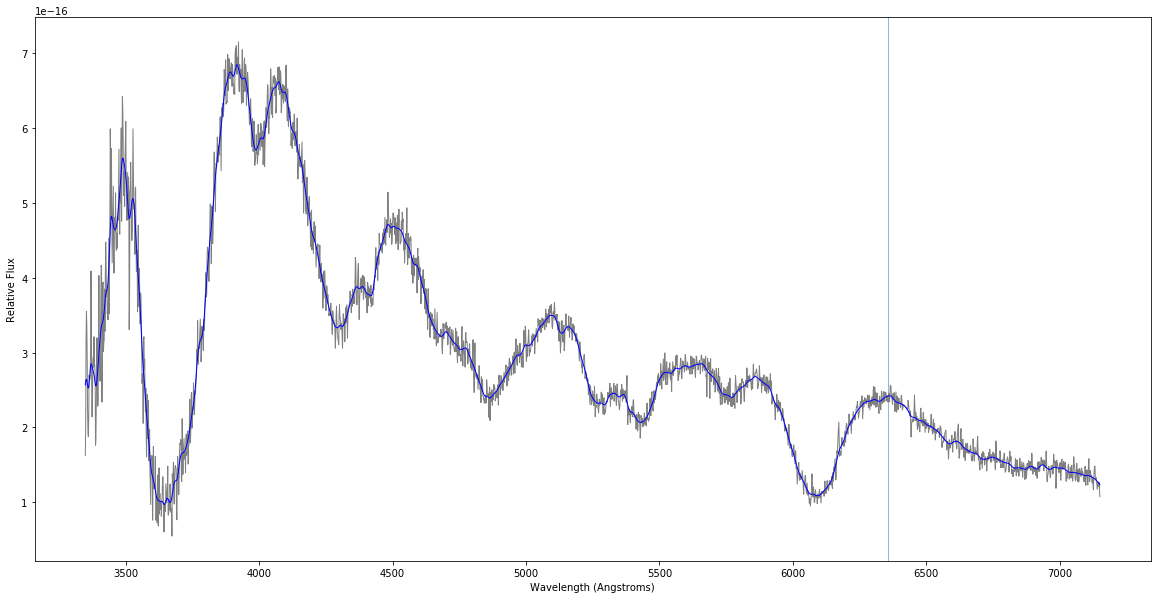

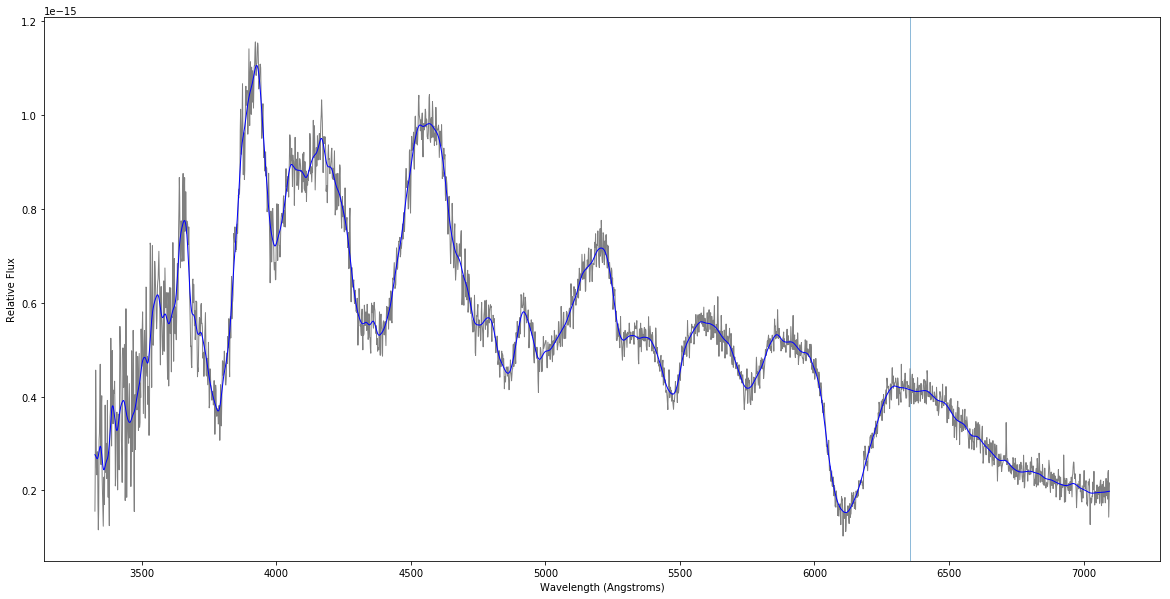

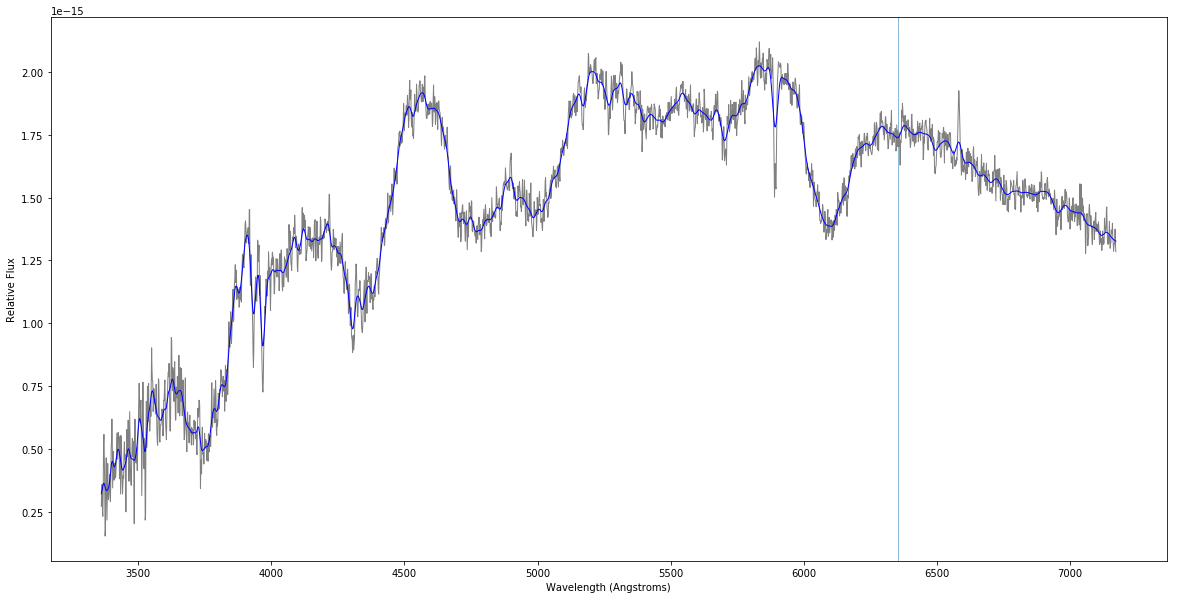

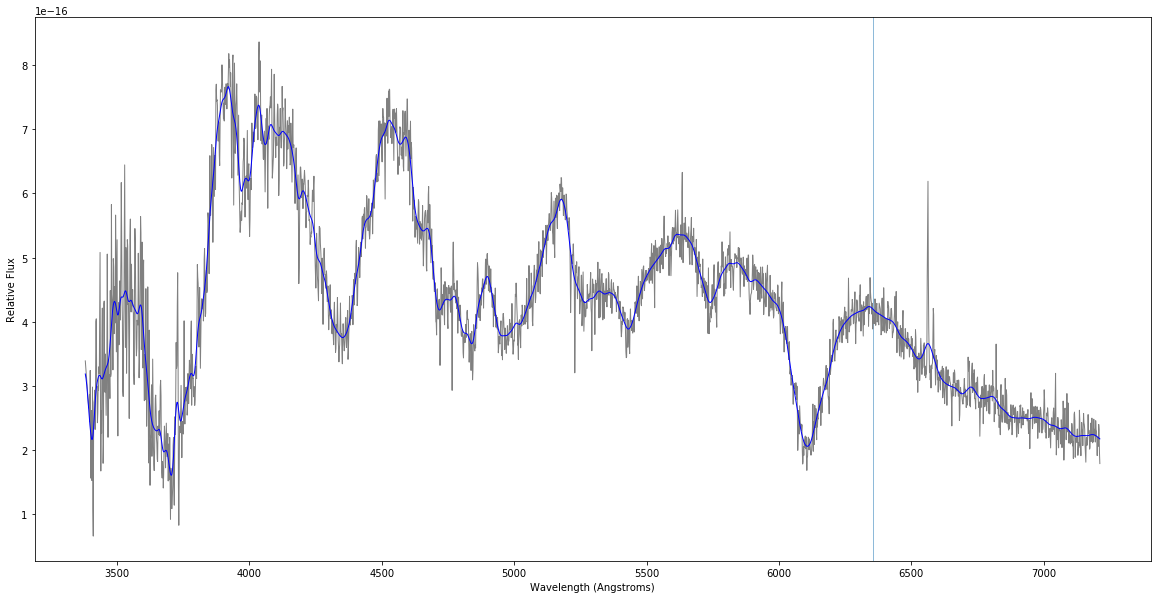

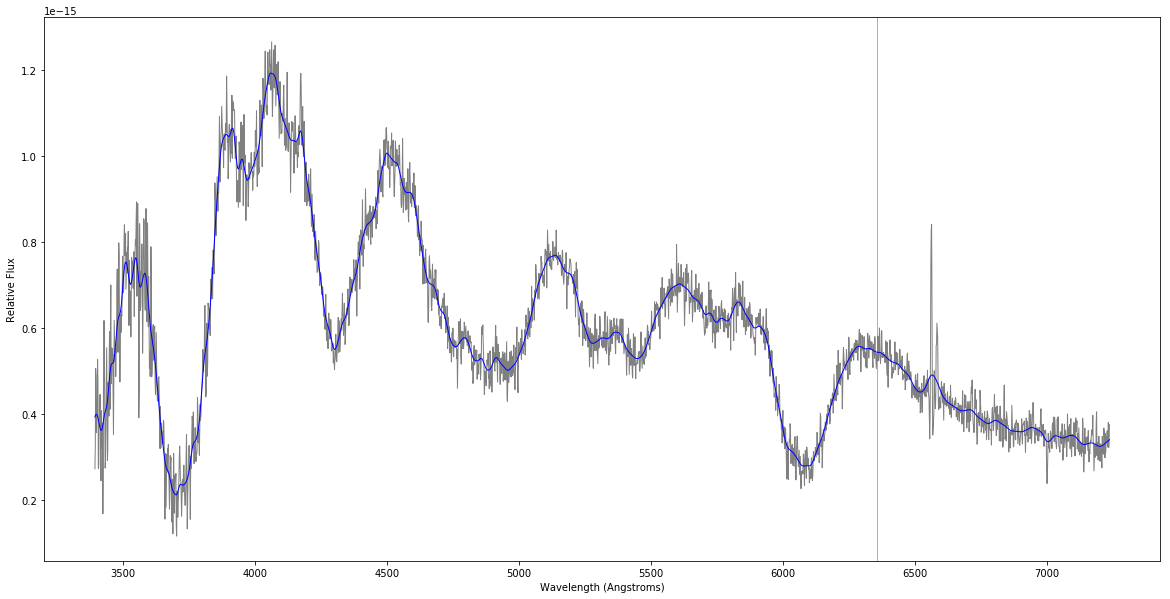

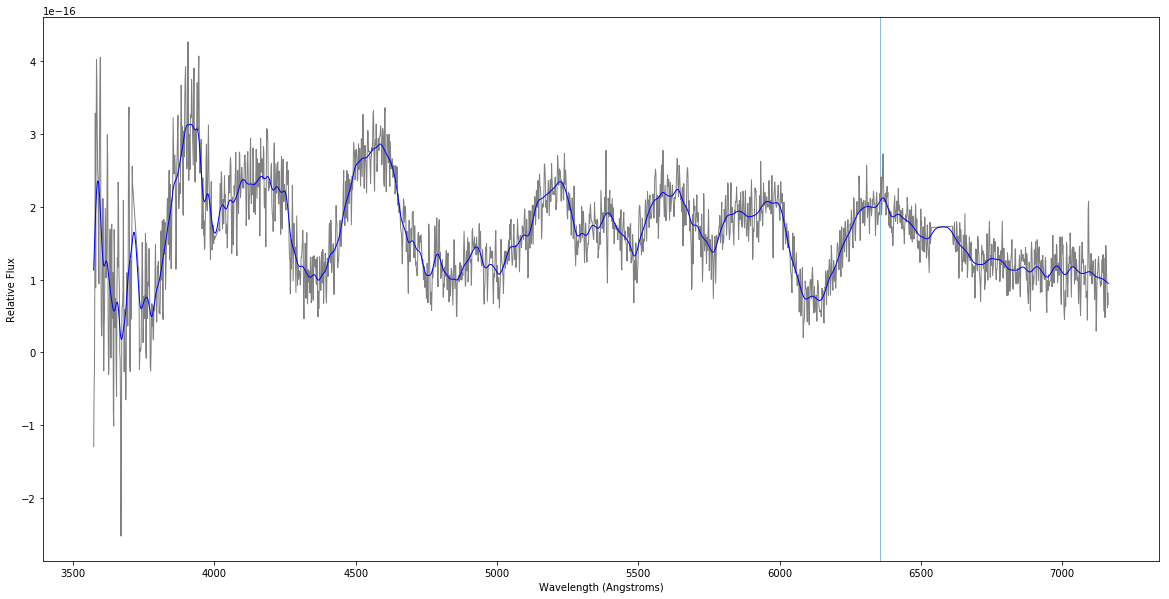

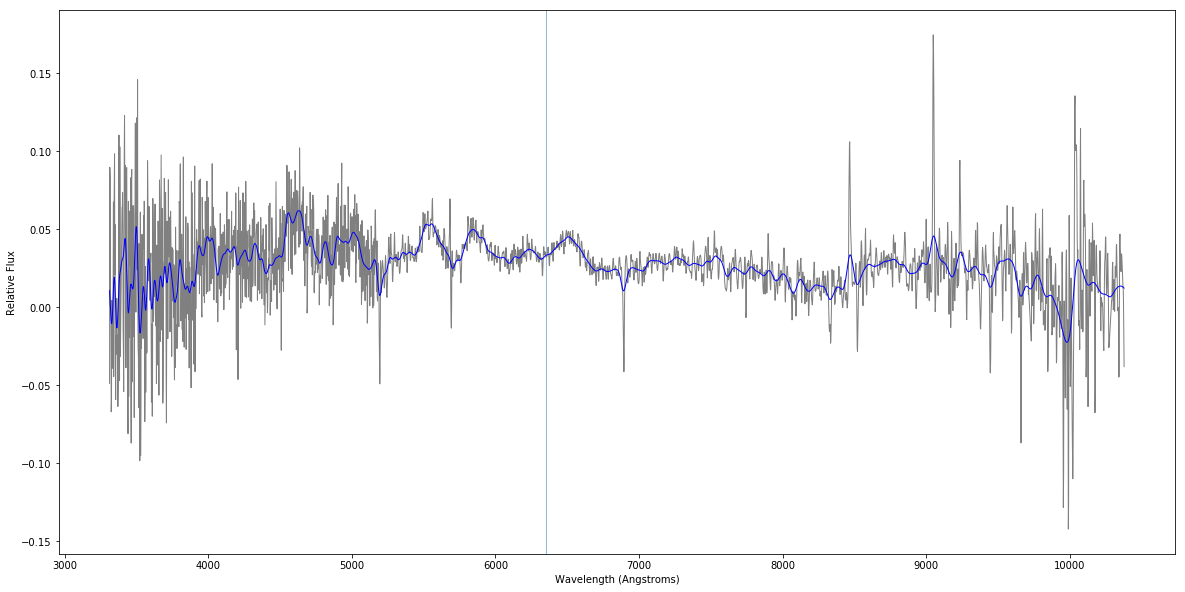

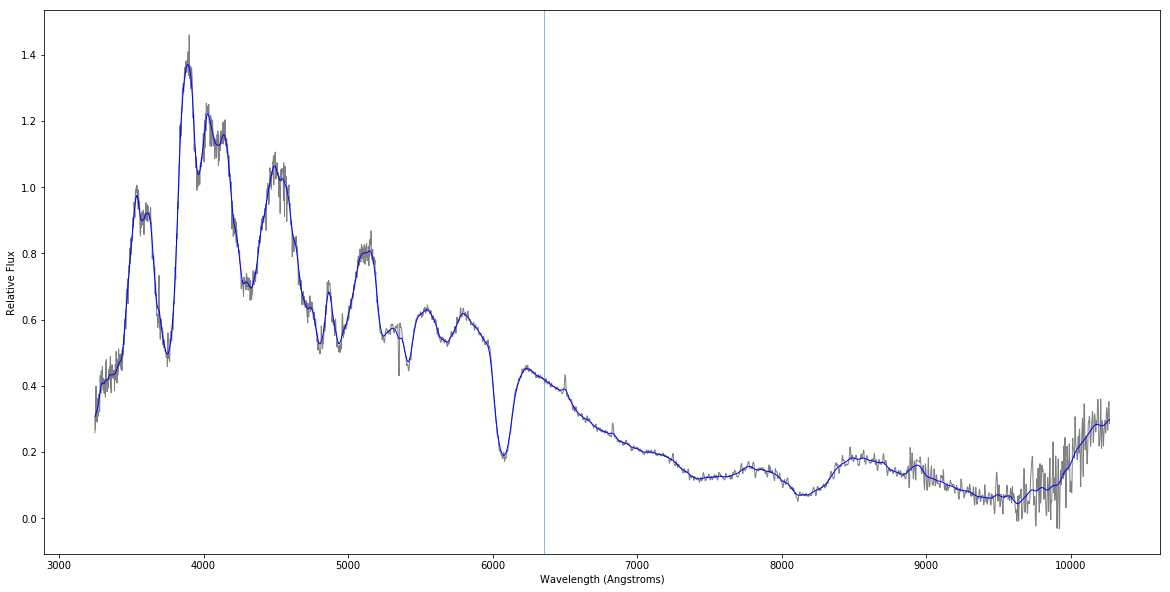

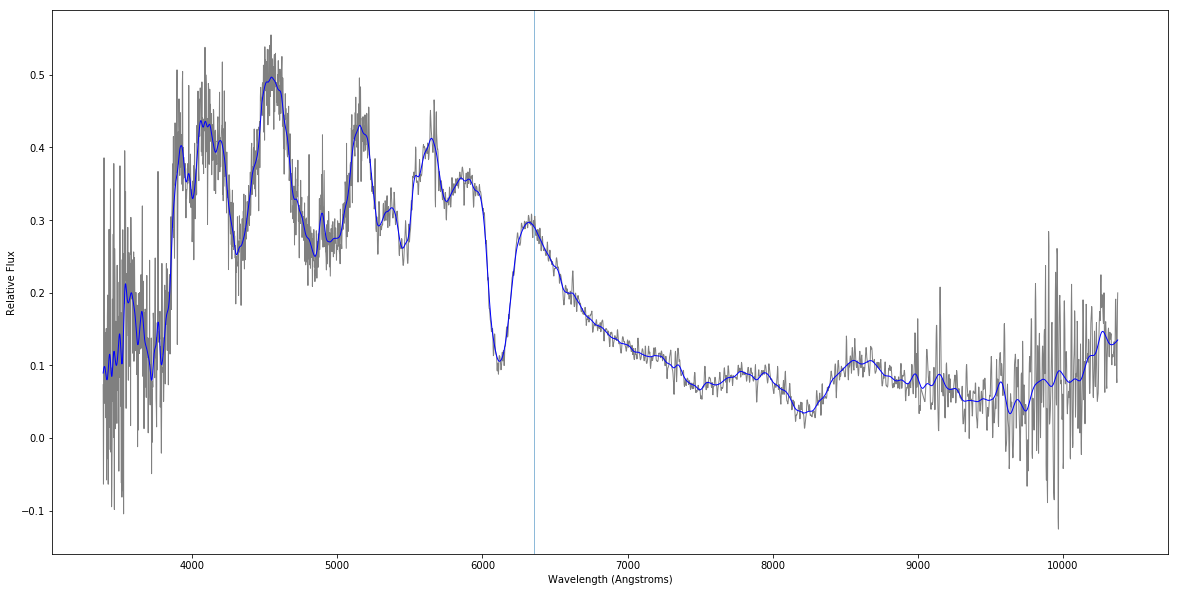

In [16]:

for a in best_spectrum_object_list:
    a.plot_spectrum()

In [17]:
best_spectrum_object_list[1].event.name

'sn2007is'

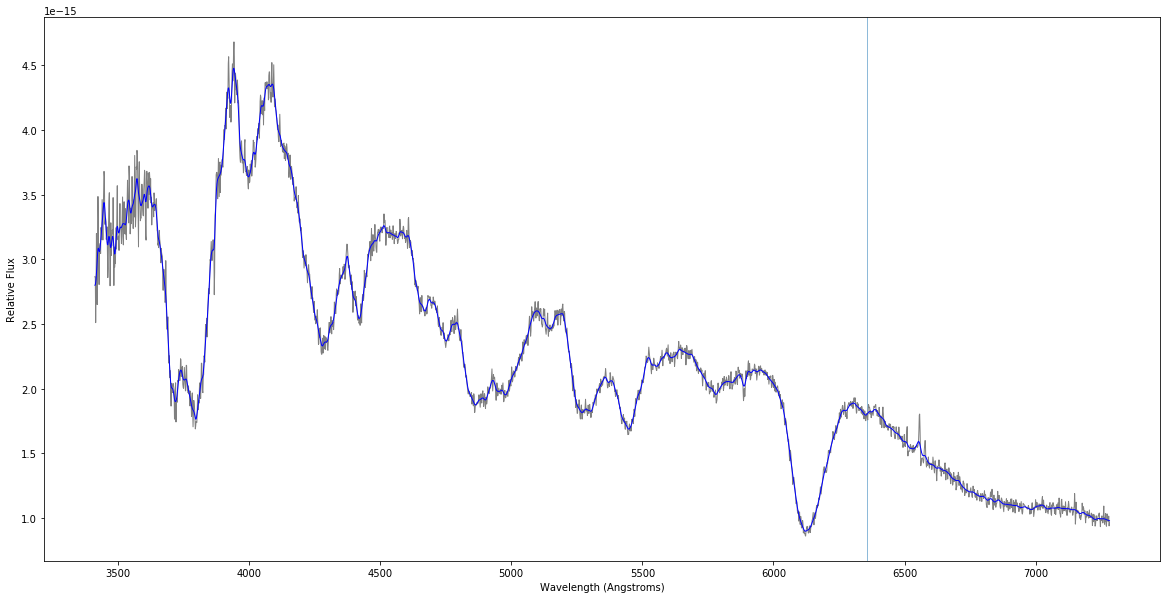

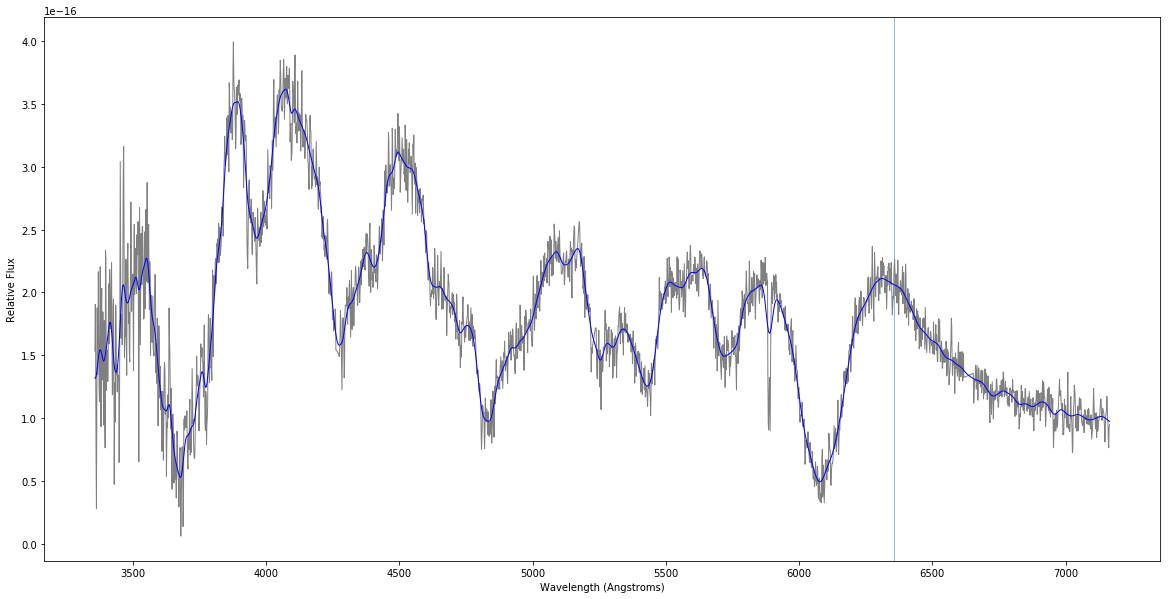

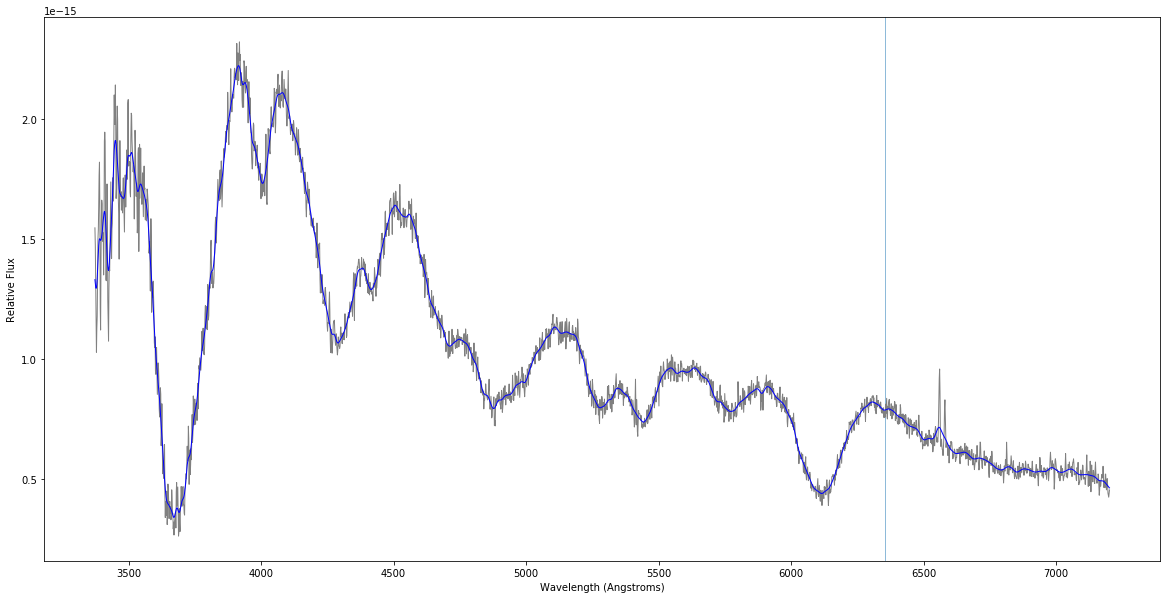

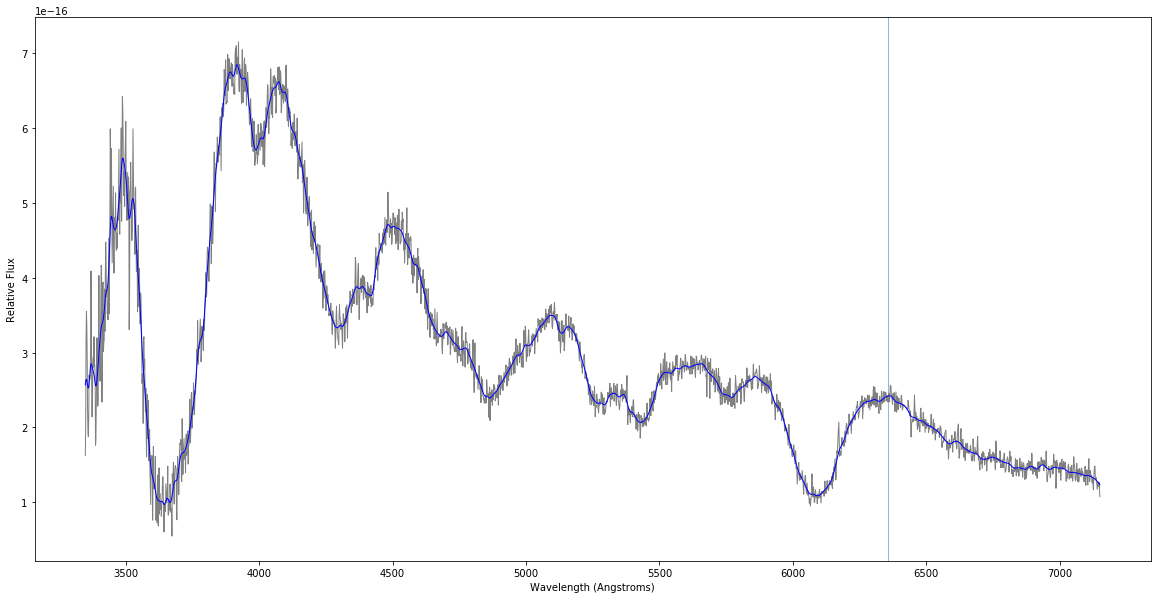

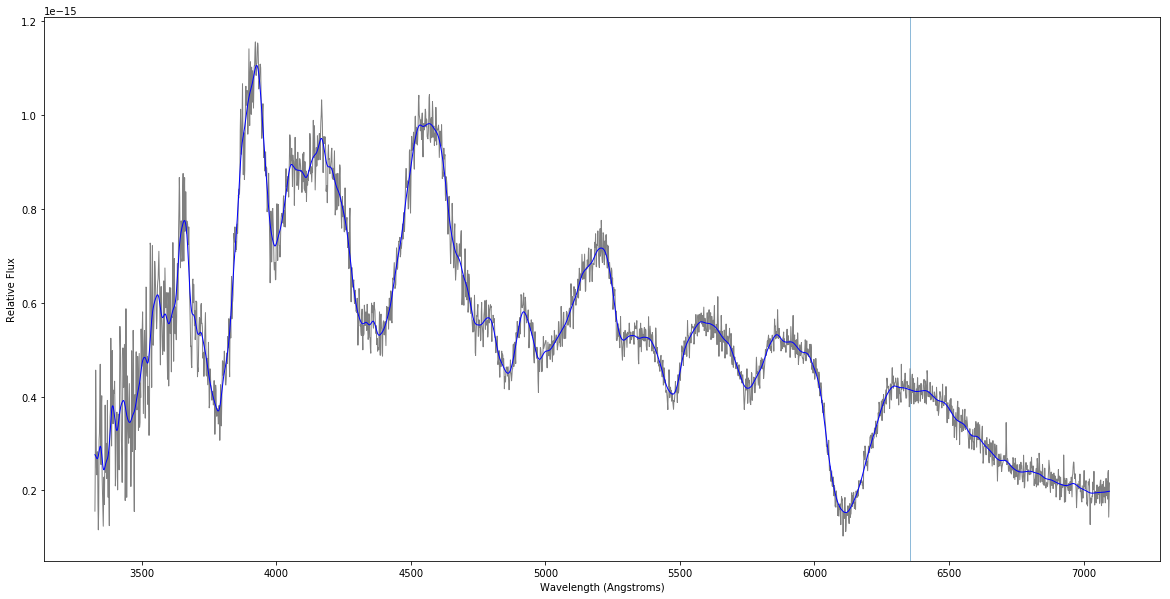

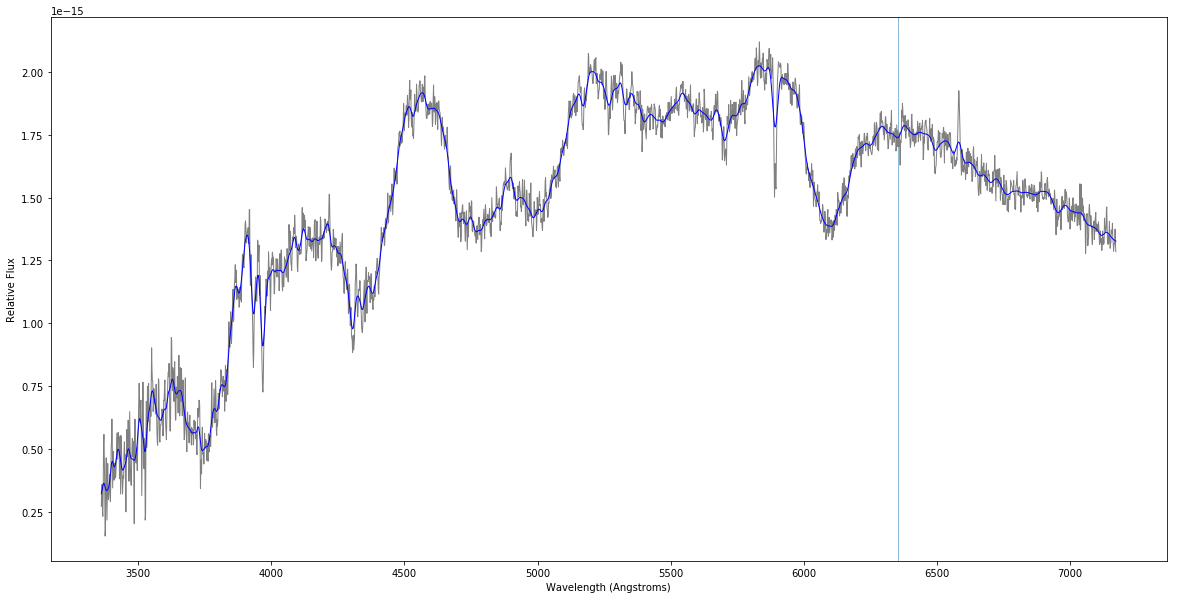

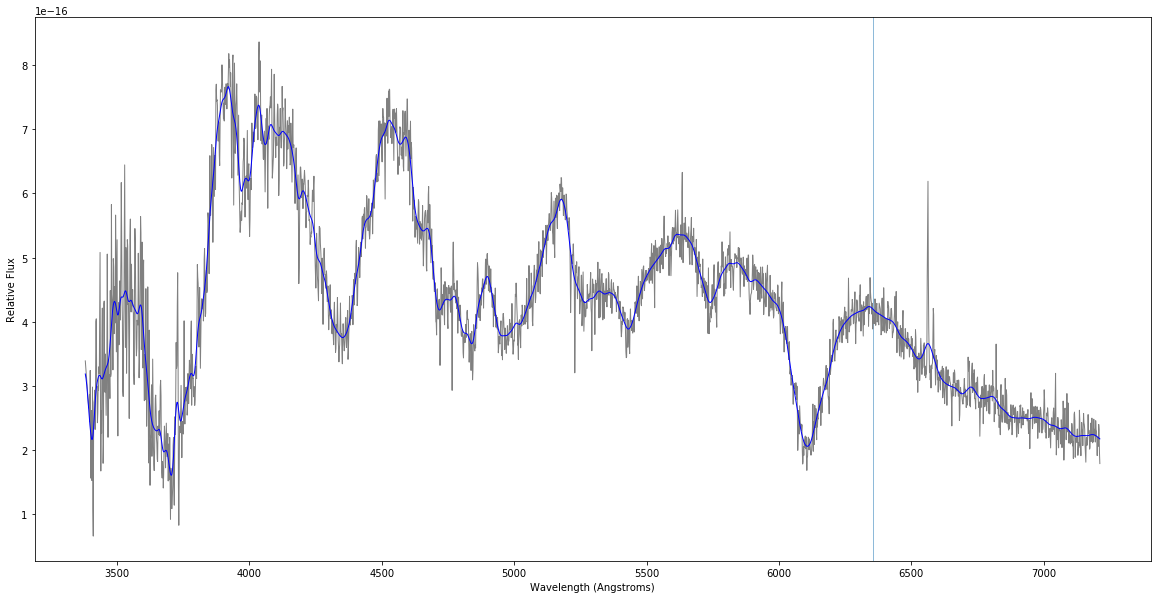

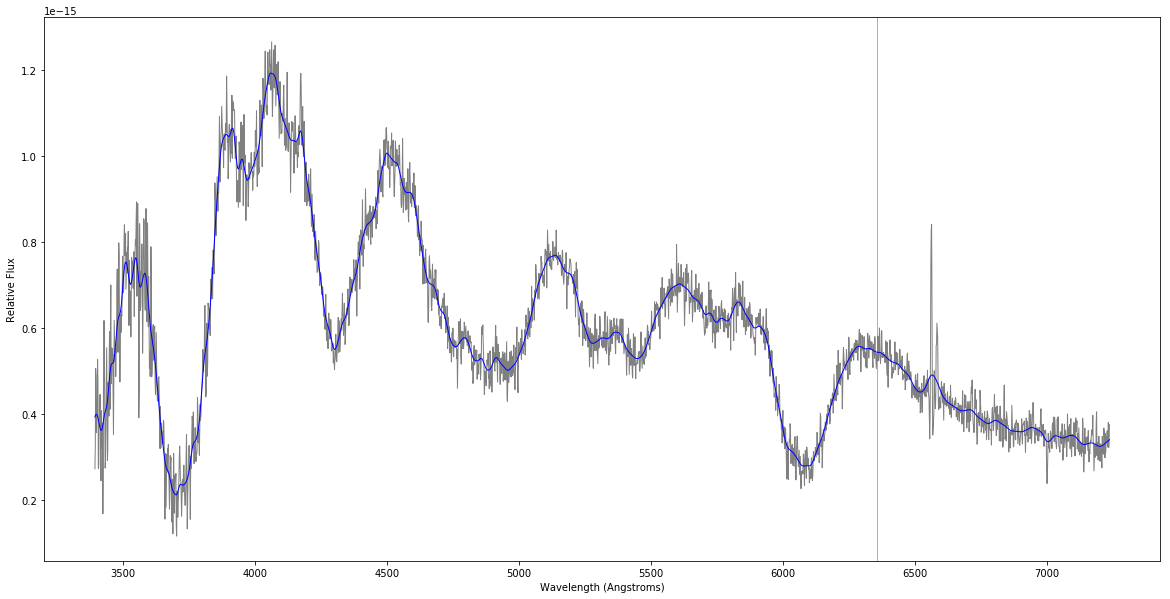

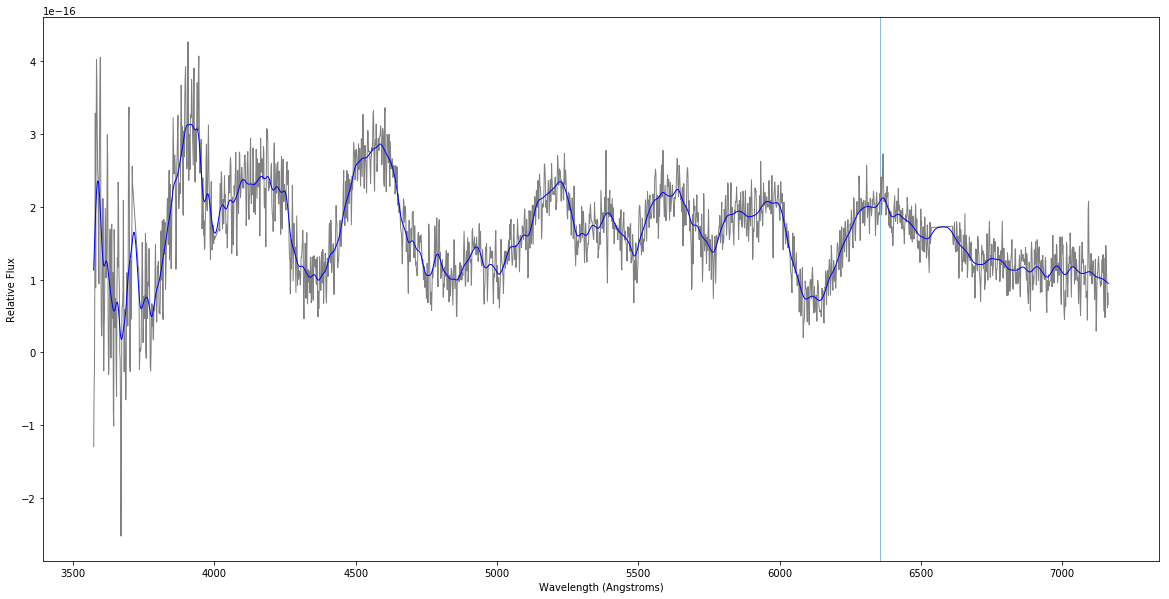

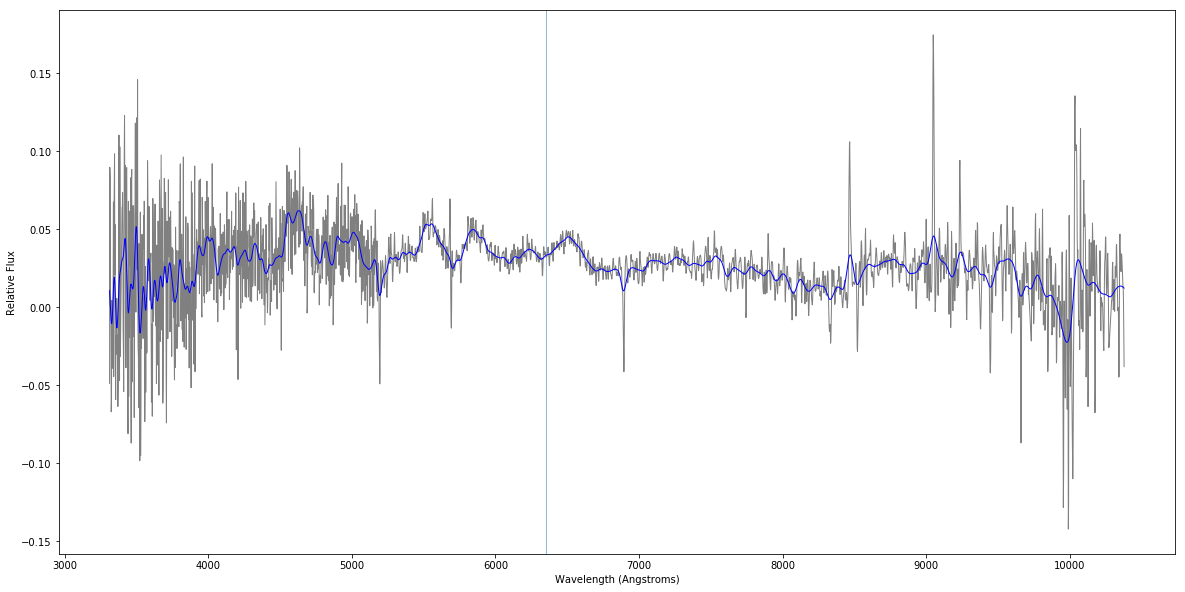

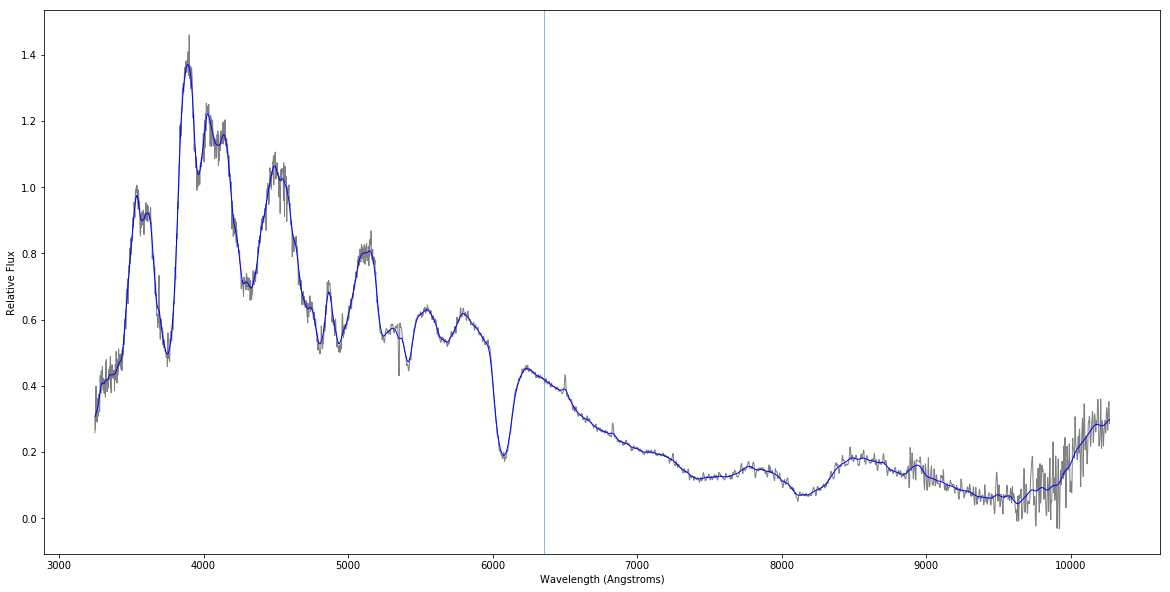

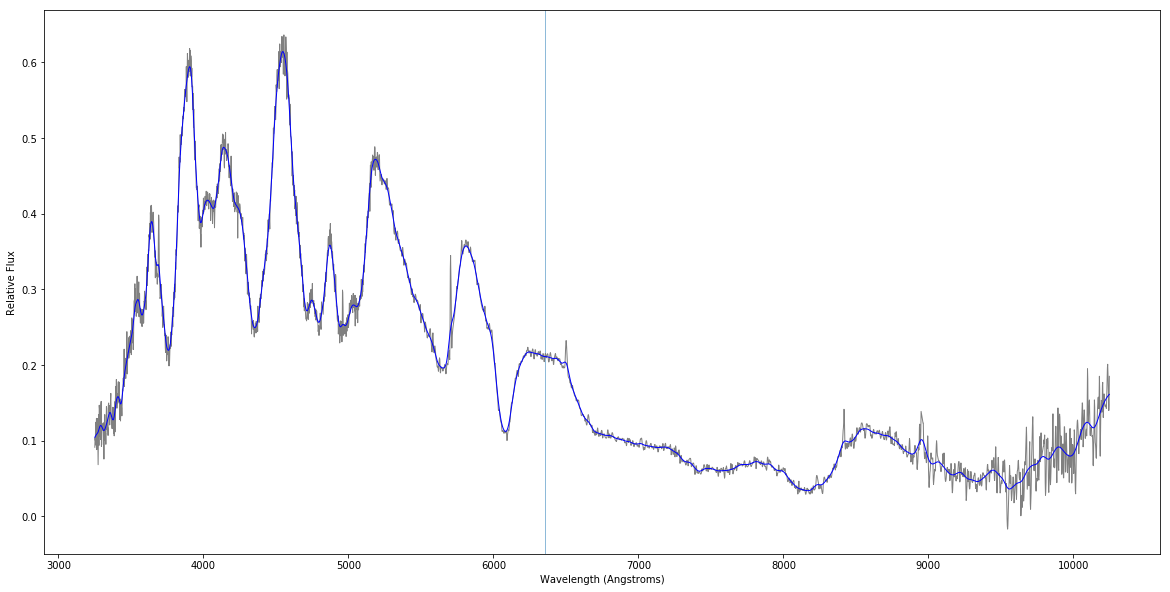

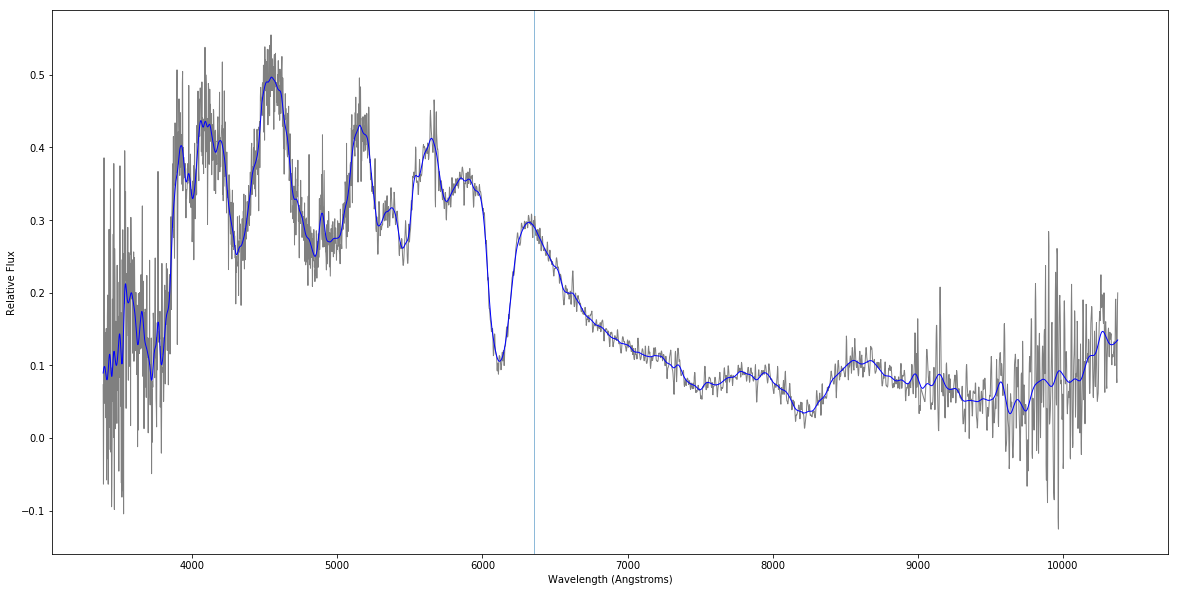

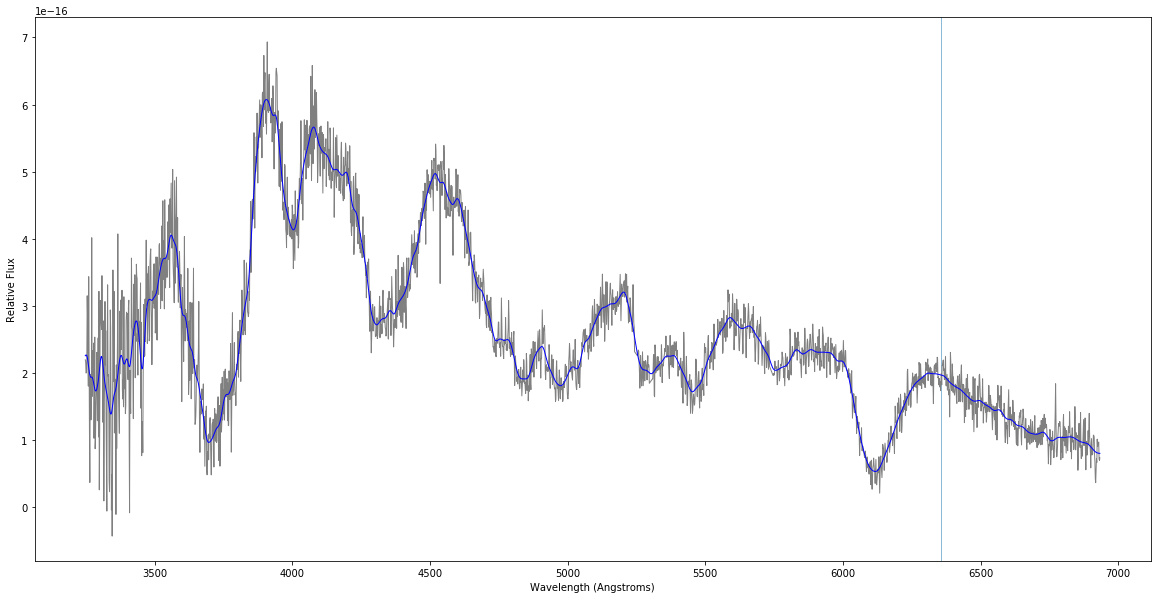

In [18]:
for a in spectrum_object_list:
    a.plot_spectrum()

In [35]:
spectrum_object_list[5].v_0_best()

Creating:  sn2007ob-20071107.14-fast.flm
sn2007ob
['sn2007ob-20071107.14-fast.flm']
[8.338114412690159]
Creating:  sn2007ob-20071107.14-fast.flm
sn2007ob


-16627.944650298876

In [20]:
for object in spectrum_object_list:
    print (object.max_wave(False, 6200, 6500), object.filename)

6306.131994819416 sn2007A-20070110.14-fast.flm
6311.6928773767595 sn2007hu-20070911.14-fast.flm
6306.680340844419 sn2007is-20070919.14-fast.flm
6361.992843719839 sn2007jg-20070920.46-fast.flm
6298.932758932509 sn2007nq-20071031.24-fast.flm
6377.95511675389 sn2007ob-20071107.14-fast.flm
6340.24800994686 sn2007su-20071229.08-fast.flm
6289.624713726683 sn2007sw-20080103.52-fast.flm
6366.563897039712 sn2008at-20080305.30-fast.flm
6499.959918523534 sn2008dt-20080908.228-ui.flm
6236.415633937083 sn2008fr-20080930.422-ui.flm
6245.948522402288 sn2008fr-20081007.368-ui.flm
6320.497392313081 sn2008hj-20081205.296-ui.flm
6312.208501723399 sn2008Y-20080209.41-fast.flm


'sn2007ob-20071107.14-fast.flm'

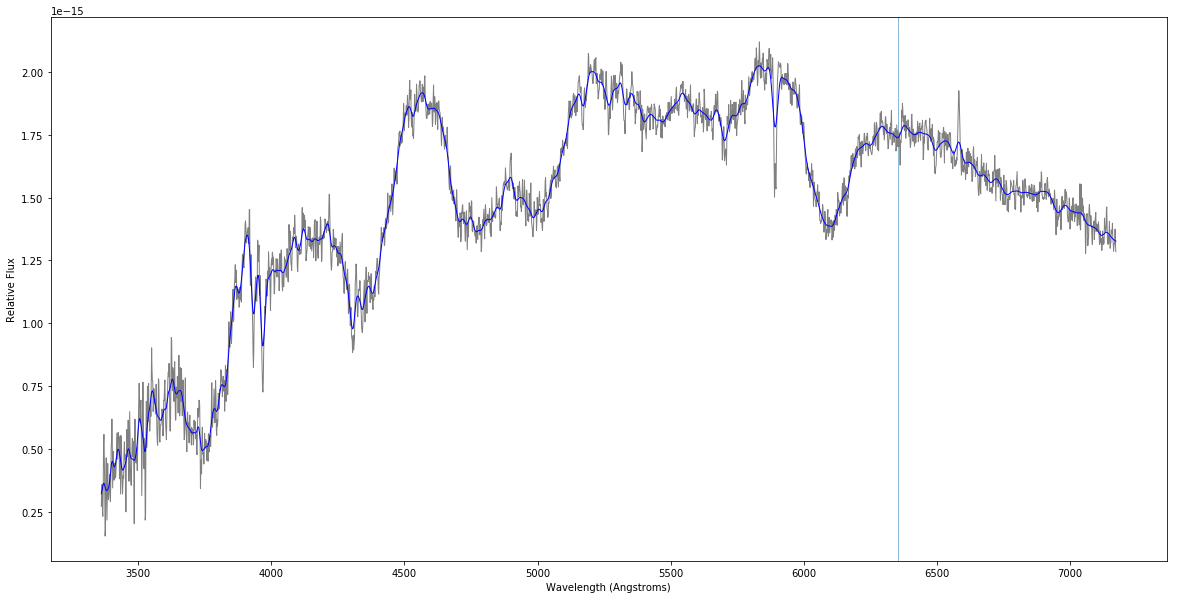

In [21]:
spectrum_object_list[5].plot_spectrum()
spectrum_object_list[5].filename

(array([3., 6., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([-16627.9446503 , -13872.3967121 , -11116.8487739 ,  -8361.30083569,
         -5605.75289749,  -2850.20495929,    -94.65702109,   2660.89091711,
          5416.43885531,   8171.98679351,  10927.53473171]),
 <a list of 10 Patch objects>)

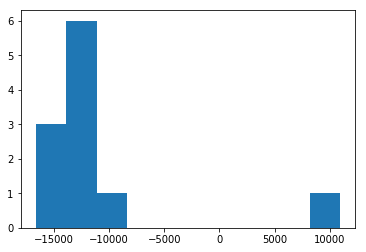

In [23]:
v_list = []
for a in best_spectrum_object_list:
    v_list.append(a.v_0())


plt.hist(v_list)

In [34]:
velocities = []
for a in spectrum_object_list:
    velocities.append(a.velocity())
print(velocities)

[-11159.73239239591, -13309.752687711783, -11516.94040251903, -12698.932453743331, -11483.188329936625, -12165.929313771796, -11920.77490137251, -12393.498726625578, -10208.677734570409, -12549.558163538457, -13343.402049901724, -13061.968696332136, -11380.565205061403, -11434.232101843092]


(array([2., 0., 0., 0., 2., 1., 1., 3., 0., 1.]),
 array([-16627.9446503 , -15969.29330891, -15310.64196753, -14651.99062614,
        -13993.33928475, -13334.68794336, -12676.03660198, -12017.38526059,
        -11358.7339192 , -10700.08257782, -10041.43123643]),
 <a list of 10 Patch objects>)

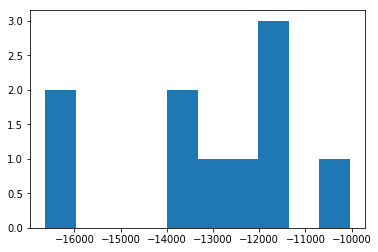

In [50]:
v_0_list = []
for b in best_spectrum_object_list:
    v_0_list.append(b.v_0())
plt.hist(v_0_list)

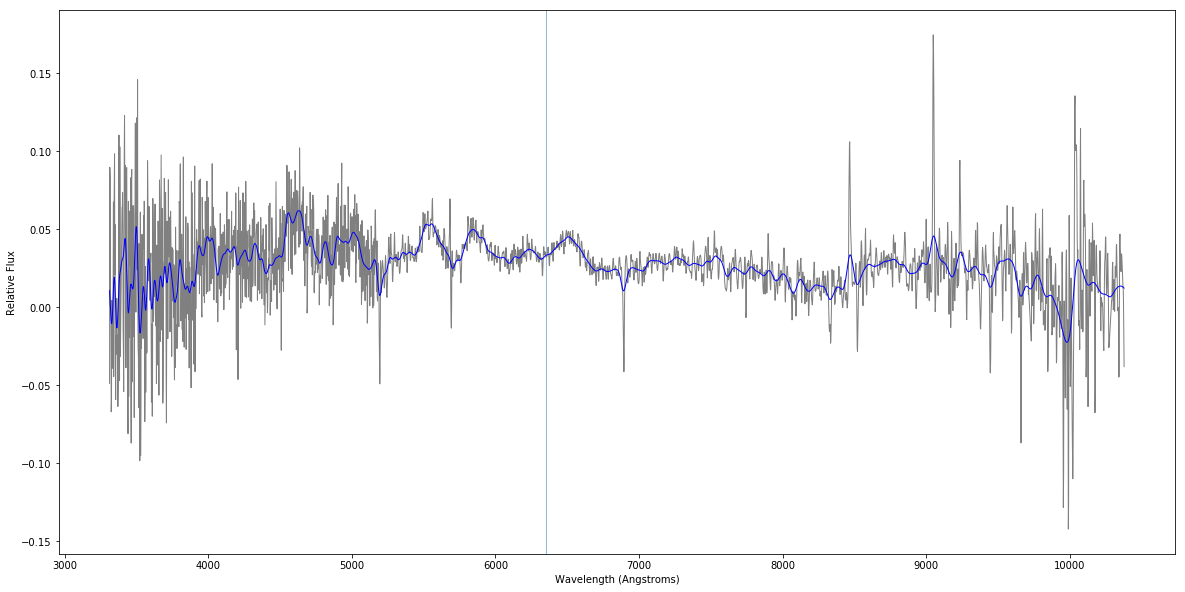

In [43]:
best_spectrum_object_list[8].plot_spectrum()

In [47]:
best_spectrum_object_list[8].filename

'sn2008dt-20080908.228-ui.flm'